In [1]:
# Show plots inline
%matplotlib inline

#%% 3-rd party libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.special import expit
from sklearn.decomposition import PCA
# import pydot_ng
import matplotlib.pyplot as plt

In [7]:
#%% Defined functions

def missing_data_by_cols(df):
    """
    Returns a pandas data frame with the columns and the percentage of missing data for each column.
    """
    missing = 100 - np.array([df[c].notnull().sum()*100.0 / df.shape[0] for c in df.columns])
    return pd.DataFrame({'Column':df.columns, 'Missing %':missing})

In [6]:
#%% Read the data

df = pd.read_csv('data_occupancy.csv')

print df.dtypes
print missing_data_by_cols(df)

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object
          Column  Missing %
0           date          0
1    Temperature          0
2       Humidity          0
3          Light          0
4            CO2          0
5  HumidityRatio          0
6      Occupancy          0


In [8]:
#%% Data Preprocessing

# Define numerical features
numerical_features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
scaled_features = [f+'_scaled' for f in numerical_features]

for f in scaled_features: df[f] = None

# Normalize
scaler = StandardScaler()
df.loc[:,scaled_features] = scaler.fit_transform(df[numerical_features])

# Softmax normalization
df.loc[:,scaled_features] = expit(df[scaled_features].values)*2.0 - 1.0

# Separate the data by groups
groups = df.groupby('Occupancy')
negatives = groups.get_group(0) 
positives = groups.get_group(1) 

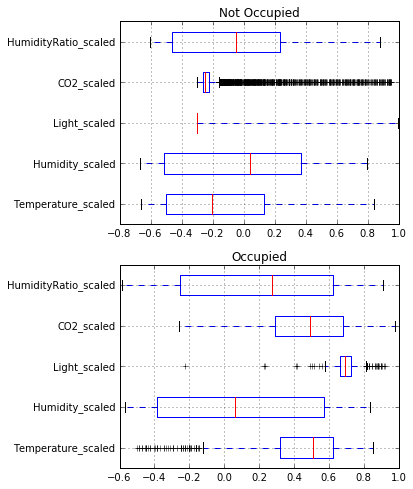

In [9]:
#%% Box plots for multiple features

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

negatives[scaled_features].plot(kind='box', vert=False, ax=ax1)
ax1.set_title('Not Occupied')
ax1.grid(True)

positives[scaled_features].plot(kind='box', vert=False, ax=ax2)
ax2.set_title('Occupied')
ax2.grid(True)

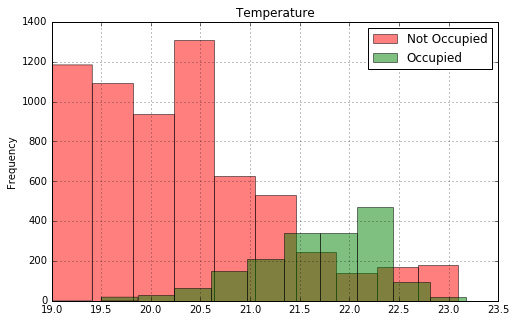

In [10]:
#%% Histograms example

fig, ax = plt.subplots(figsize=(8,5))

# Plot density of non-survived
negatives['Temperature'].plot(kind='hist', ax=ax, color='r', label='Not Occupied', alpha=0.5)
# Plot density of survived
positives['Temperature'].plot(kind='hist', ax=ax, color='g', label='Occupied', alpha=0.5)
ax.set_title('Temperature')
ax.grid(True)
ax.legend(loc='best')

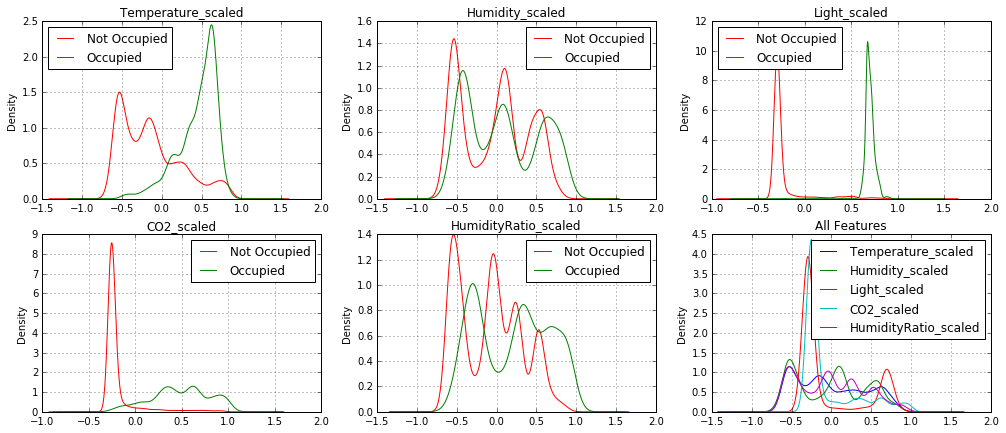

In [11]:
#%% Density plots for multiple features

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(17,7))

for f,ax in zip(scaled_features ,(ax1,ax2,ax3,ax4,ax5)):
    # Plot density of non-survived
    negatives[f].plot(kind='kde', ax=ax, color='r', label='Not Occupied')
    ax.set_title(f)
    ax.grid(True)
    # Plot density of survived
    positives[f].plot(kind='kde', ax=ax, color='g', label='Occupied')
    ax.set_title(f)
    ax.grid(True)
    ax.legend(loc='best')

df[scaled_features].plot(kind='kde', ax=ax6)
ax6.set_title('All Features')
ax6.grid(True)

% Explained variance:  [ 0.78428232  0.91923973  1.        ]


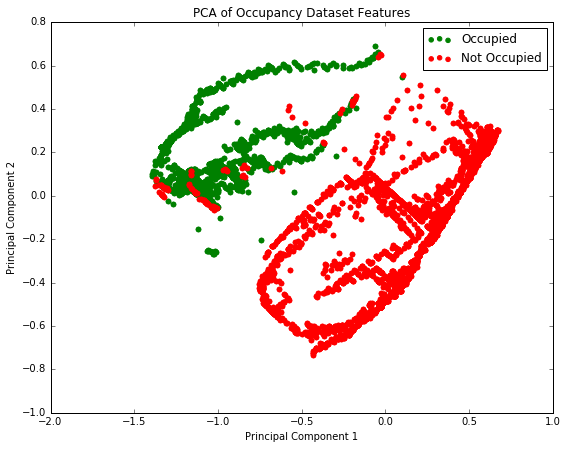

In [14]:
#%% PCA Visualization

pca_features = scaled_features
pca_features = ['Temperature_scaled','Light_scaled','CO2_scaled']

# Fit PCA and check how much variance is explained with each component
pca = PCA(n_components=None)
pca.fit(df[pca_features])
print '% Explained variance: ', pca.explained_variance_ratio_.cumsum()

# Make data frame with principal components transformations
df_prin = pd.DataFrame(pca.transform(df[pca_features])[:,[0,1]], 
                       columns=['Prin1', 'Prin2'], index=df.index)
df = pd.concat((df, df_prin), axis=1)

groups = df.groupby('Occupancy')
negatives = groups.get_group(0) 
positives = groups.get_group(1) 

# Plot first two principal components
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(positives['Prin1'], positives['Prin2'], color='g', label='Occupied')
ax.scatter(negatives['Prin1'], negatives['Prin2'], color='r', label='Not Occupied')
ax.set_title('PCA of Occupancy Dataset Features')
ax.legend(loc='best')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')